In [1]:
!ls

sample_data  test.xlsm	train.xlsm


# Построение регрессионной модели на выборке train.xlsm

1.   [Разведочный анализ датасета](#-Анализ-признаков-выборки-train.xlsm)
2.   [Выбор стратегии трансформации данных](#-Выбор-стратегии-трансформации-данных)
3.   [Предварительный отбор моделей](#-Предварительный-отбор-моделей)
4.   [Выбоор модели и предсказание на тестовом датасете](#-Стэкинг-моделей-регрессии)



In [2]:
import pandas as pd
import numpy as np
import sys
import os
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, HistGradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression, ElasticNet, SGDRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer, MinMaxScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
def stacking_results(ax, y_true, y_pred, title, scores):

    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "--r", linewidth=1)
    ax.scatter(y_true, y_pred, alpha=0.2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Фактические значения')
    ax.set_ylabel('Предсказанные значения')
    extra = plt.Rectangle(
        (0, 0), 0, 0, fc='w', fill=False, edgecolor='none', linewidth=0
    )
    ax.legend([extra], [scores], loc='upper left')
    ax.set_title(title)


def transform_plot(ax, y_test, y_pred, max_val, title,):
    ax.scatter(y_test, y_pred)
    ax.plot([0, max_val], [0, max_val], "--k")
    ax.set_ylabel("предсказанная величина")
    ax.set_xlabel("фактическая величина")
    ax.set_title(title)
    ax.text(
        1,
        1,
        r"$R^2$=%.2f, RMSE=%.2f"
        % (r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred)),
    )
    ax.set_xlim([0, max_val])
    ax.set_ylim([0, max_val])


def get_scores(regressor, scoring, X, y):    
    scores = cross_val_score(regressor, X, y, scoring=scoring, cv=5)
    return scores.mean(), scores.std()


def split_csv(s):
    s = s[0].split(',')
    res = []
    for i in s:
        if i == '':
            res.append(float('nan'))
        else:
            res.append(i)
    return res

## Анализ признаков выборки **train.xlsm**


In [4]:
df = pd.read_excel('train.xlsm', header=None, dtype=str)
dataset = df.values
dataset = [split_csv(i) for i in dataset]

train = pd.DataFrame(dataset, copy=True)

train = train.astype('float64')
train.drop(0, axis=0, inplace=True)
train.drop(0, axis=1, inplace=True)
new_columns = [f'feat_{i}' for i in range(1, len(train.columns)+1)]
new_columns.pop()
new_columns.append('y_value')
train.columns = new_columns
print(train.info())
print(train.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204 entries, 1 to 204
Data columns (total 40 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   feat_1   204 non-null    float64
 1   feat_2   203 non-null    float64
 2   feat_3   203 non-null    float64
 3   feat_4   203 non-null    float64
 4   feat_5   203 non-null    float64
 5   feat_6   203 non-null    float64
 6   feat_7   202 non-null    float64
 7   feat_8   99 non-null     float64
 8   feat_9   99 non-null     float64
 9   feat_10  99 non-null     float64
 10  feat_11  99 non-null     float64
 11  feat_12  99 non-null     float64
 12  feat_13  202 non-null    float64
 13  feat_14  202 non-null    float64
 14  feat_15  99 non-null     float64
 15  feat_16  202 non-null    float64
 16  feat_17  202 non-null    float64
 17  feat_18  202 non-null    float64
 18  feat_19  202 non-null    float64
 19  feat_20  99 non-null     float64
 20  feat_21  99 non-null     float64
 21  feat_22  99 non-

На данном этапе видно номера фичей у которых пропущены ~50% значений *(8-12, 15, 20-22, 25)*
эти фичи использоваться не будут, остальные будут дополнены инструментом **SimpleImputer**.

In [5]:
sparse_features = [f'feat_{i}' for i in [8,9,10,11,12,15,20,21,22,25]]
train.drop(sparse_features, axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matp

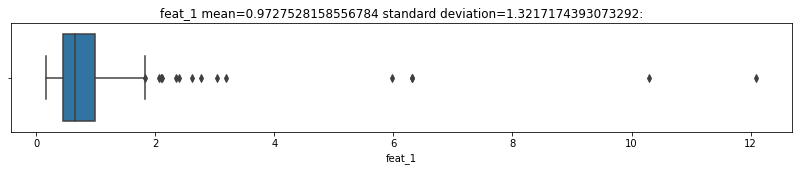

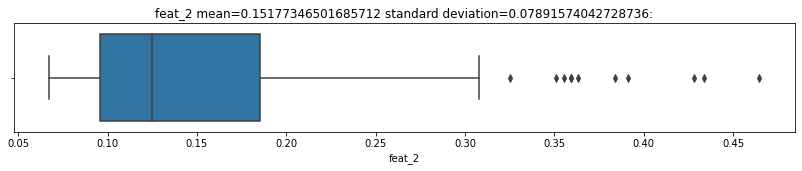

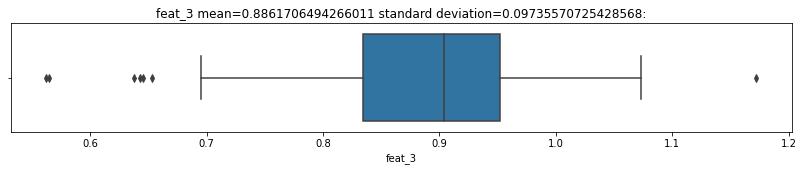

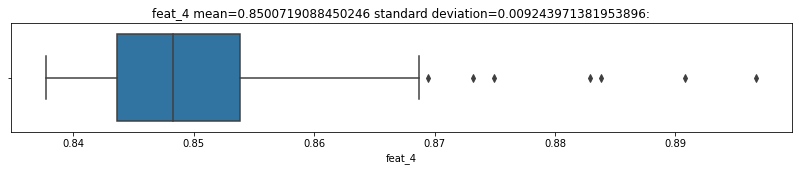

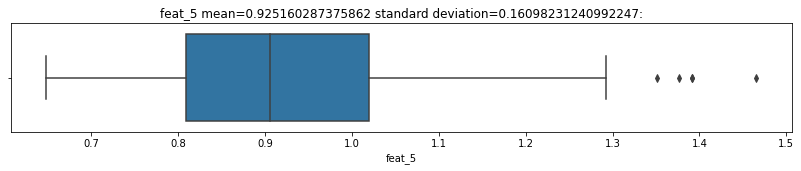

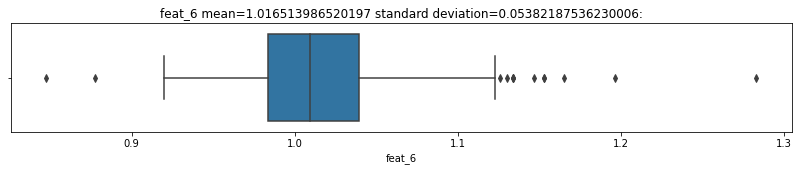

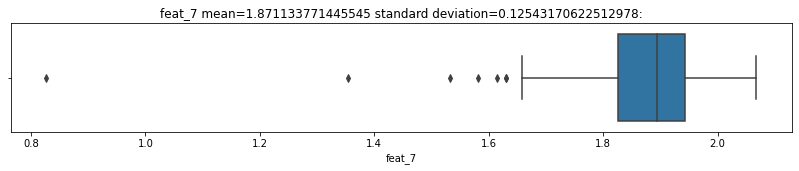

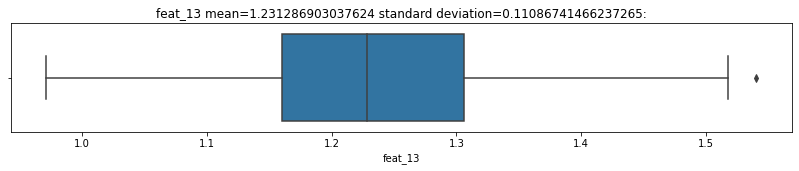

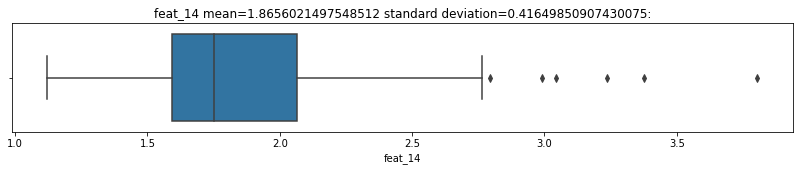

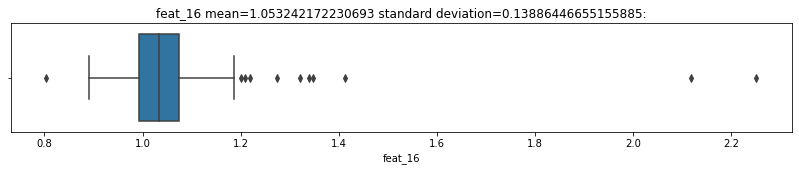

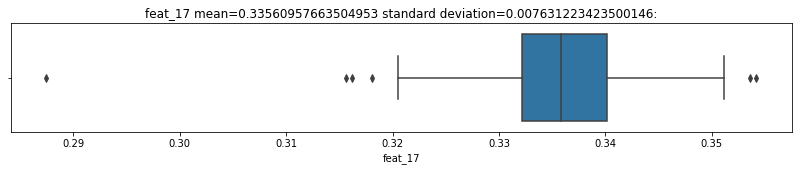

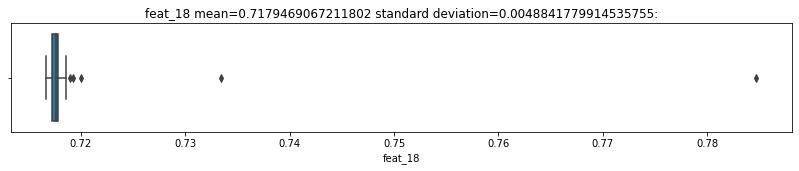

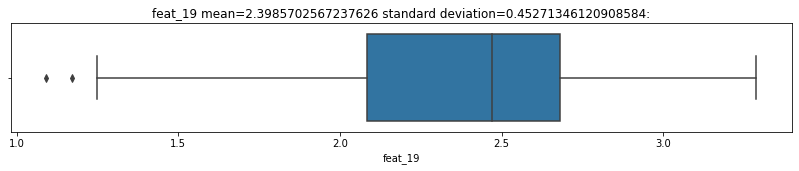

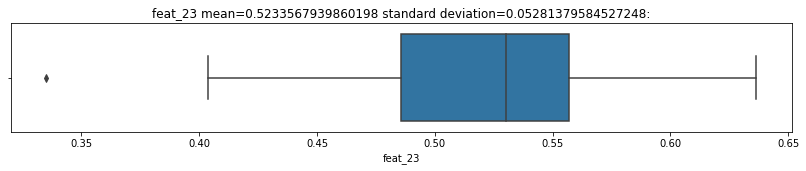

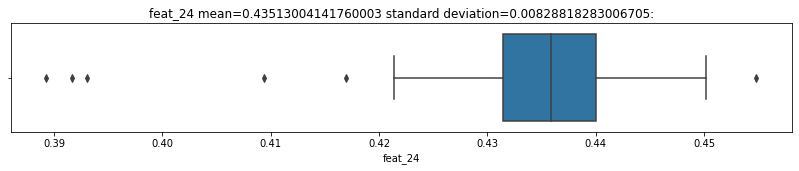

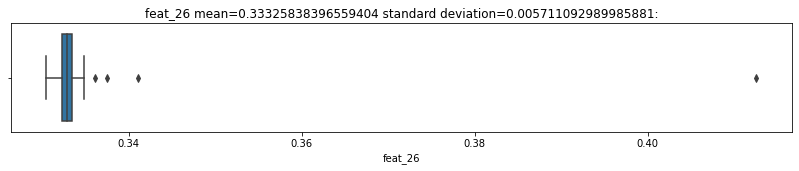

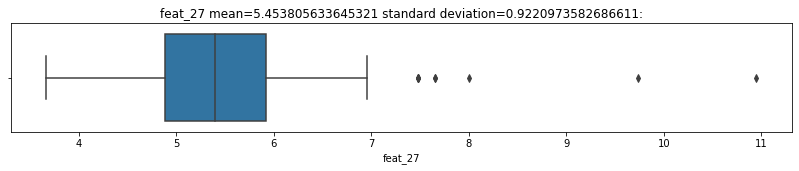

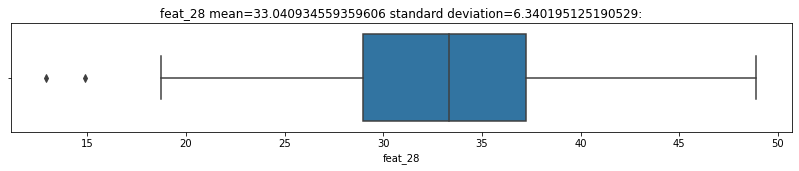

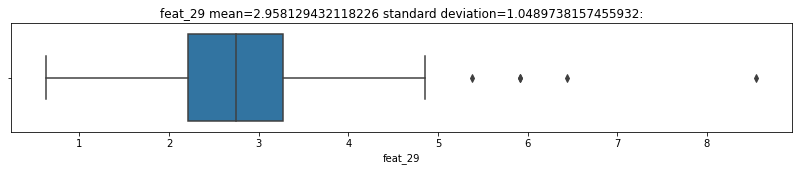

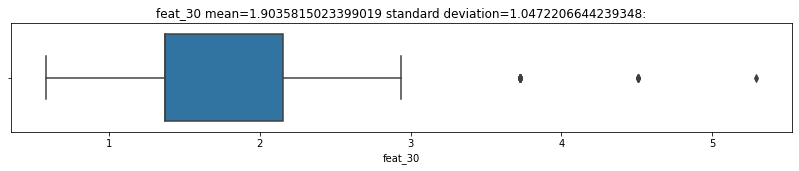

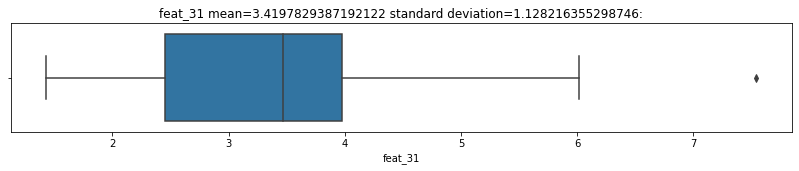

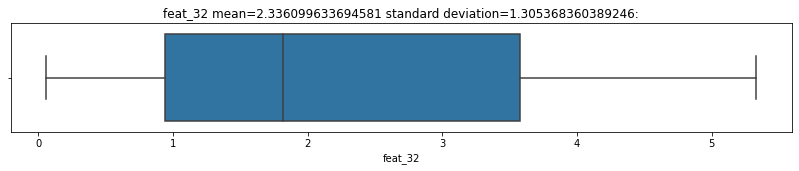

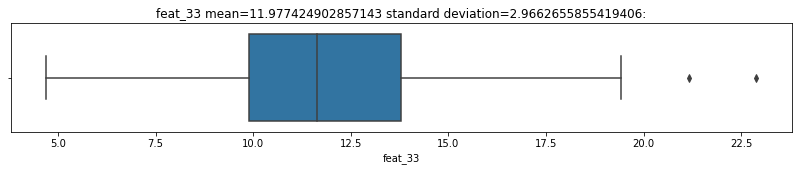

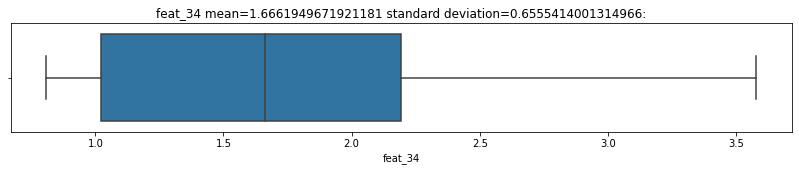

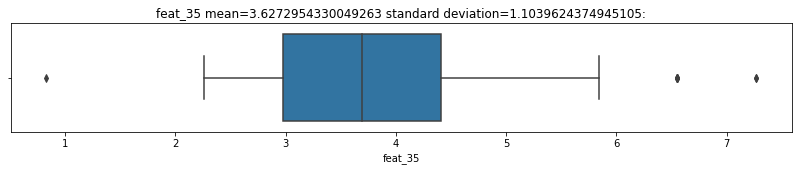

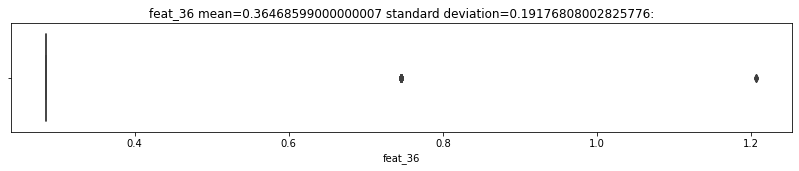

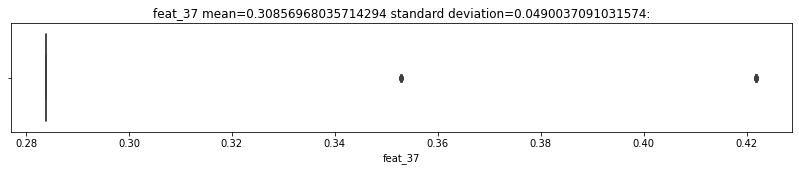

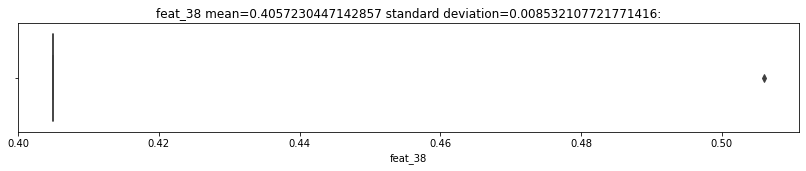

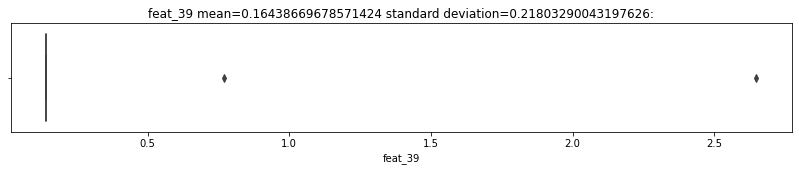

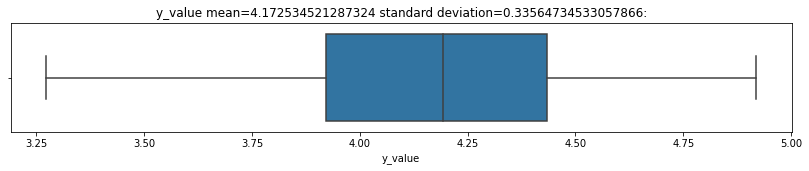

In [6]:
for col in train.columns:
    data = train[col]
    fig, ax = plt.subplots(figsize=(14, 2))
    sns.boxplot(x=data)
    plt.title(f'{col} mean={data.mean()} standard deviation={data.std()}:')
plt.show()

Признаки обладают небольшим количеством выбросов, также видно что фичи имеют почти сопоставимый масштаб, но для работы с линейными регрессорами
датасету может потребоваться соответсвующая стратегия трансформации (наличие выбросов и сопоставимый масштаб: StandardScaler)

In [7]:
cor = train.corr()
for i in cor.columns:
    cor_target = abs(cor[i])    
    relevant_features = cor_target[cor_target>0.5]
    print('Коэффициенты корреляции для признака', i)
    print(relevant_features)

Коэффициенты корреляции для признака feat_1
feat_1    1.0
Name: feat_1, dtype: float64
Коэффициенты корреляции для признака feat_2
feat_2     1.000000
feat_4     0.756639
feat_37    0.764157
Name: feat_2, dtype: float64
Коэффициенты корреляции для признака feat_3
feat_3     1.000000
feat_27    0.518409
Name: feat_3, dtype: float64
Коэффициенты корреляции для признака feat_4
feat_2     0.756639
feat_4     1.000000
feat_37    0.656928
Name: feat_4, dtype: float64
Коэффициенты корреляции для признака feat_5
feat_5     1.000000
feat_14    0.624668
Name: feat_5, dtype: float64
Коэффициенты корреляции для признака feat_6
feat_6     1.000000
feat_33    0.563955
Name: feat_6, dtype: float64
Коэффициенты корреляции для признака feat_7
feat_7     1.000000
feat_27    0.506829
Name: feat_7, dtype: float64
Коэффициенты корреляции для признака feat_13
feat_13    1.0
Name: feat_13, dtype: float64
Коэффициенты корреляции для признака feat_14
feat_5     0.624668
feat_14    1.000000
feat_16    0.640597


Анализ зависимости между признаками показал наличие корреляций в группах (3, 27) (4, 2) (30, 34)
(19, 28) (19, 27) (28, 27) (5, 14) (16, 14)

In [8]:
correlated_features = [f'feat_{i}' for i in [4, 28, 37]]
train.drop(correlated_features, axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warnin

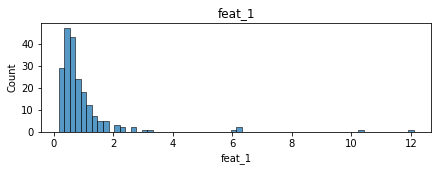

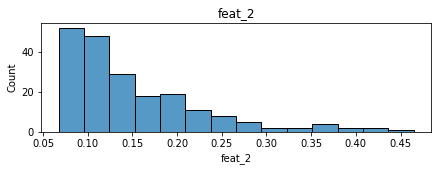

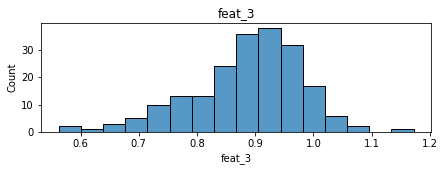

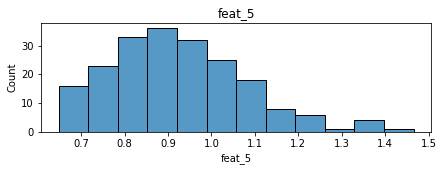

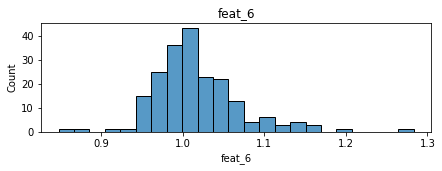

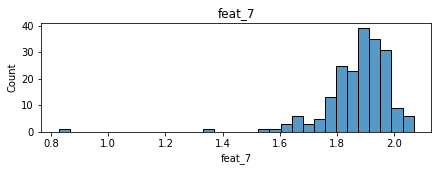

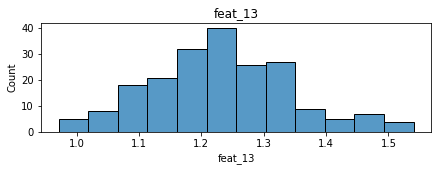

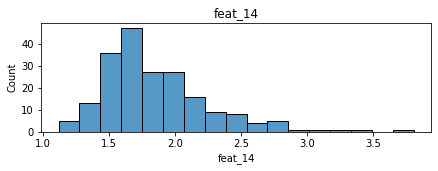

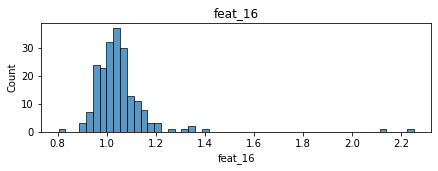

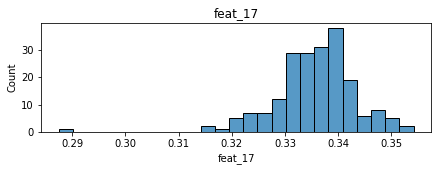

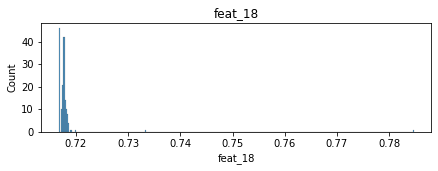

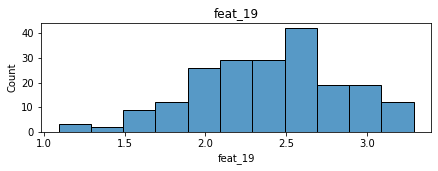

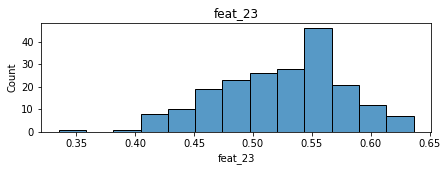

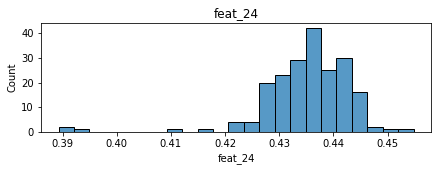

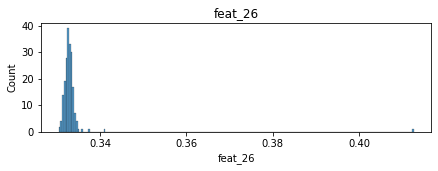

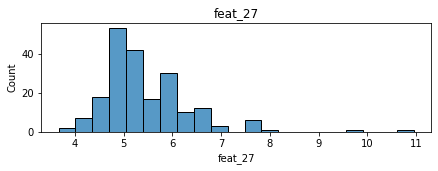

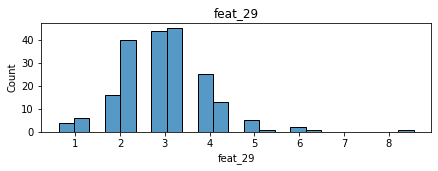

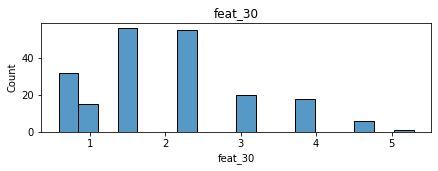

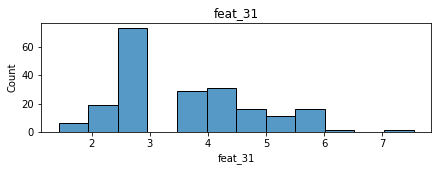

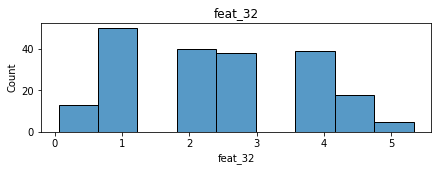

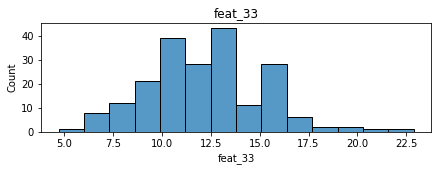

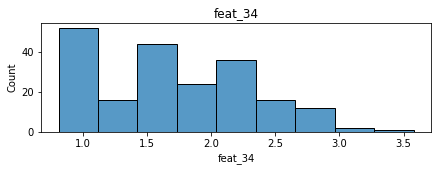

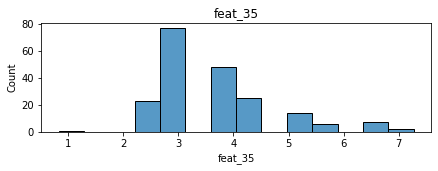

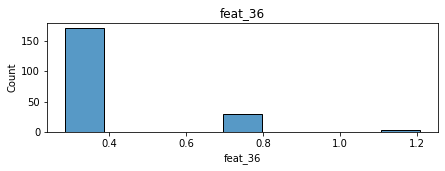

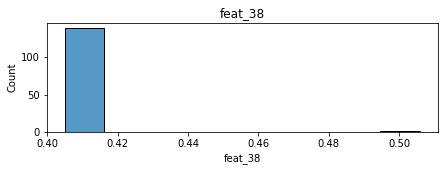

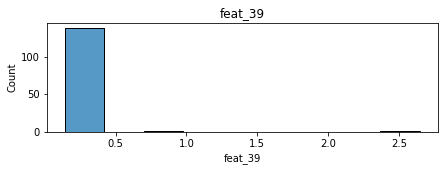

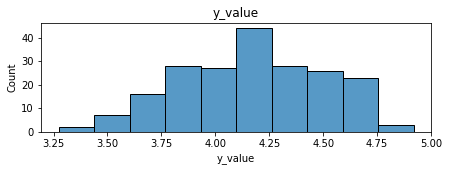

In [9]:
for col in train.columns:
    fig, ax = plt.subplots(figsize=(7, 2))
    sns.histplot(data=train, x=train[col])
    plt.title(f'{col}')
plt.show()

Анализ характера распределения признаков показал наличие небольшого количества выбросов, различия масштаба значений признаков датасете. Для улучшения результативности регрессионных моделей могут быть применяться различные стратегии трансформации данных. Ниже приведено предварительное тестирование работы регрессионной модели деревьев решений на датасете с трансформацией данных и без.

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204 entries, 1 to 204
Data columns (total 27 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   feat_1   204 non-null    float64
 1   feat_2   203 non-null    float64
 2   feat_3   203 non-null    float64
 3   feat_5   203 non-null    float64
 4   feat_6   203 non-null    float64
 5   feat_7   202 non-null    float64
 6   feat_13  202 non-null    float64
 7   feat_14  202 non-null    float64
 8   feat_16  202 non-null    float64
 9   feat_17  202 non-null    float64
 10  feat_18  202 non-null    float64
 11  feat_19  202 non-null    float64
 12  feat_23  202 non-null    float64
 13  feat_24  202 non-null    float64
 14  feat_26  202 non-null    float64
 15  feat_27  203 non-null    float64
 16  feat_29  203 non-null    float64
 17  feat_30  203 non-null    float64
 18  feat_31  203 non-null    float64
 19  feat_32  203 non-null    float64
 20  feat_33  203 non-null    float64
 21  feat_34  203 non

## Выбор стратегии трансформации данных

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


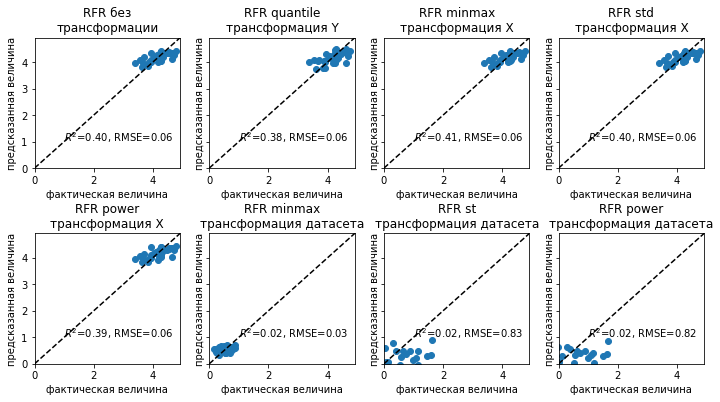

In [11]:
X = train.values[:, :-1]
y = train.values[:, -1]
imputer = SimpleImputer()
imputer.fit(X)
X = imputer.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)
regr = RandomForestRegressor(random_state=0)
regr_name = 'RFR'

f, axs = plt.subplots(2, 4, sharey=True, figsize=(12, 6), gridspec_kw=dict(hspace=.5))
# 1 Сравнение использования линейной модели на исходных данных
y_max_val = y.max()

regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
transform_plot(axs[0, 0], y_test, y_pred, y_max_val, f'{regr_name} без\nтрансформации')

# 2 Сравнение использования линейной модели на трансформированных Y
regr_trans = TransformedTargetRegressor(regressor=regr,
                                        transformer=QuantileTransformer(n_quantiles=80,
                                                                        output_distribution="normal"))

regr_trans.fit(X_train, y_train)
y_pred = regr_trans.predict(X_test)
transform_plot(axs[0, 1], y_test, y_pred, y_max_val, f'{regr_name} quantile\nтрансформация Y')

# 3
minmax = MinMaxScaler()
X_train_minmax = minmax.fit_transform(X_train)
X_test_minmax = minmax.transform(X_test)
regr.fit(X_train_minmax, y_train)
y_pred = regr.predict(X_test_minmax)
transform_plot(axs[0, 2], y_test, y_pred, y_max_val, f'{regr_name} minmax\nтрансформация Х')

# 4
st = StandardScaler()
X_train_st = st.fit_transform(X_train)
X_test_st = st.transform(X_test)
regr.fit(X_train_st, y_train)
y_pred = regr.predict(X_test_st)
transform_plot(axs[0, 3], y_test, y_pred, y_max_val, f'{regr_name} std\nтрансформация Х')

# 5
pw = PowerTransformer()
X_train_pw = pw.fit_transform(X_train)
X_test_pw = pw.transform(X_test)
regr.fit(X_train_pw, y_train)
y_pred = regr.predict(X_test_pw)
transform_plot(axs[1, 0], y_test, y_pred, y_max_val, f'{regr_name} power\nтрансформация Х')

# 6
full_data = train.values
full_data = SimpleImputer().fit_transform(full_data)
full_minmax = MinMaxScaler()
full_minmax.fit(full_data)
minmax_data = full_minmax.transform(full_data)
X_train_mm, X_test_mm, y_train_mm, y_test_mm = train_test_split(minmax_data[:, :-1], minmax_data[:, -1],
                                                                test_size=.2, random_state=42)

regr.fit(X_train_mm, y_train_mm)
y_pred = regr.predict(X_test_mm)
transform_plot(axs[1, 1], y_test_mm, y_pred, y_max_val, f'{regr_name} minmax\nтрансформация датасета')

# 7
full_st = StandardScaler()
full_st.fit(full_data)
st_data = full_st.transform(full_data)
X_train_st, X_test_st, y_train_st, y_test_st = train_test_split(st_data[:, :-1], st_data[:, -1],
                                                                test_size=.2, random_state=42)

regr.fit(X_train_st, y_train_st)
y_pred = regr.predict(X_test_st)
transform_plot(axs[1, 2], y_test_st, y_pred, y_max_val, f'{regr_name} st\nтрансформация датасета')

# 8
full_pt = PowerTransformer()
full_pt.fit(full_data)
pt_data = full_pt.transform(full_data)
X_train_pt, X_test_pt, y_train_pt, y_test_pt = train_test_split(pt_data[:, :-1], pt_data[:, -1],
                                                                test_size=.2, random_state=42)

regr.fit(X_train_pt, y_train_pt)
y_pred = regr.predict(X_test_pt)
transform_plot(axs[1, 3], y_test_pt, y_pred, y_max_val, f'{regr_name} power\nтрансформация датасета')
plt.show()

Результаты предварительного тестирования различных стратегий линейных и нелинейных трансформаций не показали улучшения результативности регрессионной модели деревьев решений на данном датасете, далее при работе с регрессорами деревьев решений трансформации данных для данного датасета производиться не будут. 
 
Для предварительного выбора моделей регрессии отобрано по одной модели из семейств **SVM**, **ensamble** и **SGD**,
поскольку в текущем исследовании выборка и набор признаков невелики, в количестве *204* и *26* соответственно,
из семейства моделей линейной регрессии подойдет модель с типом регуляризации **L2 - Ridge**.

## Предварительный отбор моделей

In [12]:
regressor0 = RandomForestRegressor(random_state=0)
regressor1 = Ridge(random_state=0)
regressor2 = RidgeCV()
regressor3 = LinearRegression()
regressor4 = ElasticNet(random_state=0)
regressor5 = SVR()
regressor6 = SGDRegressor(random_state=0)
Model_N = 7

r2_mean = np.zeros(Model_N)
RMSE_mean = np.zeros(Model_N)
r2_std = np.zeros(Model_N)
RMSE_std = np.zeros(Model_N)
reg_labels = []

# для r2
r2_mean[0], r2_std[0] = get_scores(regressor0, 'r2', X, y)
reg_labels.append('RFR_r2')
r2_mean[1], r2_std[1] = get_scores(regressor1, 'r2', X, y)
reg_labels.append('Rid_r2')
r2_mean[2], r2_std[2] = get_scores(regressor2, 'r2', X, y)
reg_labels.append('RCV_r2')
r2_mean[3], r2_std[3] = get_scores(regressor3, 'r2', X, y)
reg_labels.append('LR_r2')
r2_mean[4], r2_std[4] = get_scores(regressor4, 'r2', X, y)
reg_labels.append('EN_r2')
r2_mean[5], r2_std[5] = get_scores(regressor5, 'r2', X, y)
reg_labels.append('SVR_r2')
r2_mean[6], r2_std[6] = get_scores(regressor6, 'r2', X, y)
reg_labels.append('SGD_r2')

# для RMSE
RMSE_mean[0], RMSE_std[0] = get_scores(regressor0, 'neg_root_mean_squared_error', X, y)
reg_labels.append('RFR_RMSE')
RMSE_mean[1], RMSE_std[1] = get_scores(regressor1, 'neg_root_mean_squared_error', X, y)
reg_labels.append('Rid_RMSE')
RMSE_mean[2], RMSE_std[2] = get_scores(regressor2, 'neg_root_mean_squared_error', X, y)
reg_labels.append('RCV_RMSE')
RMSE_mean[3], RMSE_std[3] = get_scores(regressor3, 'neg_root_mean_squared_error', X, y)
reg_labels.append('LR_RMSE')
RMSE_mean[4], RMSE_std[4] = get_scores(regressor4, 'neg_root_mean_squared_error', X, y)
reg_labels.append('EN_RMSE')
RMSE_mean[5], RMSE_std[5] = get_scores(regressor5, 'neg_root_mean_squared_error', X, y)
reg_labels.append('SVR_RMSE')
RMSE_mean[6], RMSE_std[6] = get_scores(regressor6, 'neg_root_mean_squared_error', X, y)
reg_labels.append('SGD_RMSE')

RMSE_mean = RMSE_mean * -1

print('r2_mean', r2_mean)
print('r2_std', r2_std)
print('RMSE_mean', RMSE_mean)
print('RMSE_std', RMSE_std)

r2_mean [  0.24114399   0.07940754   0.07940754 -62.36187837  -0.11894128
   0.06966285  -0.42447657]
r2_std [2.36376203e-01 2.22395275e-01 2.22395275e-01 1.05728392e+02
 4.07739887e-02 1.99036568e-01 5.01704909e-01]
RMSE_mean [0.27332464 0.30305106 0.30305106 1.66422851 0.3394494  0.30560799
 0.37576656]
RMSE_std [0.03785514 0.03202693 0.03202693 2.07492679 0.03904561 0.03280758
 0.07863451]


Из вышеизложенного видно, что модель из семейста **ensemble** показывает наилучший результат по метрике **r2**
ниже чем при сравнении алгоритмов трансформации, что обусловлено использованием инструмента **cross_val_score**
однако стандартное отклонение по данной метрике высоко, что свидетельствует о высой вариативности
предсказаний модели на данном этапе.
 
Далее производится поиск наилучших параметров для трех регрессионных моделей семества ensemble инструментом **GridSearchCV**

In [13]:
RFR = RandomForestRegressor(random_state=11)
RFR_param = {'n_estimators' : [i for i in range(10, 110, 10)],
             'criterion' : ['absolute_error']}
ABR = AdaBoostRegressor(random_state=22)
ABR_param = {'n_estimators' : [i for i in range(10, 110, 10)],
             'loss' :  ['linear', 'square', 'exponential']}
HGBR = HistGradientBoostingRegressor(random_state=0)
HGBR_param = {'max_iter' : [i for i in range(10, 110, 10)],
             'loss' :  ['absolute_error', 'poisson'],
              'max_leaf_nodes' : [10, 20, 31]}

RFR_r2 = GridSearchCV(estimator=RFR, param_grid=RFR_param, scoring='r2', cv=3)
RFR_r2.fit(X, y)
print('RFR_r2.best_score_', RFR_r2.best_score_)
print('RFR_r2.best_params_', RFR_r2.best_params_)
RFR_RMSE = GridSearchCV(estimator=RFR, param_grid=RFR_param, scoring='neg_root_mean_squared_error', cv=3)
RFR_RMSE.fit(X, y)
print('RFR_RMSE.best_score_', RFR_RMSE.best_score_)
print('RFR_RMSE.best_params_', RFR_RMSE.best_params_)

ABR_r2 = GridSearchCV(estimator=ABR, param_grid=ABR_param, scoring='r2', cv=3)
ABR_r2.fit(X, y)
print('ABR_r2.best_score_', ABR_r2.best_score_)
print('ABR_r2.best_params_', ABR_r2.best_params_)
ABR_RMSE = GridSearchCV(estimator=ABR, param_grid=ABR_param, scoring='neg_root_mean_squared_error', cv=3)
ABR_RMSE.fit(X, y)
print('ABR_RMSE.best_score_', ABR_RMSE.best_score_)
print('ABR_RMSE.best_params_', ABR_RMSE.best_params_)

HGBR_r2 = GridSearchCV(estimator=HGBR, param_grid=HGBR_param, scoring='r2', cv=3)
HGBR_r2.fit(X, y)
print('HGBR_r2.best_score_', HGBR_r2.best_score_)
print('HGBR_r2.best_params_', HGBR_r2.best_params_)
HGBR_RMSE = GridSearchCV(estimator=HGBR, param_grid=HGBR_param, scoring='neg_root_mean_squared_error', cv=3)
HGBR_RMSE.fit(X, y)
print('HGBR_RMSE.best_score_', HGBR_RMSE.best_score_)
print('HGBR_RMSE.best_params_', HGBR_RMSE.best_params_)

RFR_r2.best_score_ 0.2798881175055725
RFR_r2.best_params_ {'criterion': 'absolute_error', 'n_estimators': 100}
RFR_RMSE.best_score_ -0.2782710419528374
RFR_RMSE.best_params_ {'criterion': 'absolute_error', 'n_estimators': 100}
ABR_r2.best_score_ 0.2700906325730868
ABR_r2.best_params_ {'loss': 'square', 'n_estimators': 50}
ABR_RMSE.best_score_ -0.2796799966456914
ABR_RMSE.best_params_ {'loss': 'square', 'n_estimators': 50}
HGBR_r2.best_score_ 0.29984576188289863
HGBR_r2.best_params_ {'loss': 'absolute_error', 'max_iter': 90, 'max_leaf_nodes': 10}
HGBR_RMSE.best_score_ -0.2742697944519248
HGBR_RMSE.best_params_ {'loss': 'absolute_error', 'max_iter': 90, 'max_leaf_nodes': 10}


Наилучшей результативностью на данном этапе обладают модели **HistGradientBoostingRegressor** и **RandomForestRegressor**.<br>
<br>
Отбор наилучших параметров на данном этапе рекомендуется производить по метрике **r2** *(наилучший результат: модель HGBR с r2=0.2998)*, так
как она обладает чувствительностью к вариативности предсказаний модели. <br>
<br>
При исследовании результативности моделей методом **GridSearchCV** наблюдается снижение метрики, так как метод задействует алгоритм кросс-валидации, с учетом небольшой численности выборки **n=\~200**, а также отсеивания зависимых признаков и признаков с содержанием более **50%** пропущенных данных, модели обучающиеся на данной выборке будут обладать высокой вариативностью предсказаний целевого признака.<br>
<br>
Для улучшения метрик данных моделей, а так же снижения вариативности предсказаний для данных моделей, в качестве результирующей модели будет использована комбинация из моделей семейста **ensemble**. 

## Стэкинг моделей регрессии

In [14]:
RCV = RidgeCV()
# HGBR = HistGradientBoostingRegressor(random_state=0)
# RFR = RandomForestRegressor(random_state=11)
# ABR = AdaBoostRegressor(random_state=22)
HGBR = HistGradientBoostingRegressor(loss='absolute_error', max_iter=90, max_leaf_nodes=10, random_state=0)
RFR = RandomForestRegressor(criterion='absolute_error', n_estimators=100, random_state=11)
# ABR = AdaBoostRegressor(loss='exponential', n_estimators=80, random_state=22)
estimators = [
    ('Random Forest', RFR),    
    ('Ridge', RCV),
    ('Gradient Boosting', HGBR)
]

stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RCV)
stacking_regressor

StackingRegressor(estimators=[('Random Forest',
                               RandomForestRegressor(criterion='absolute_error',
                                                     random_state=11)),
                              ('Ridge',
                               RidgeCV(alphas=array([ 0.1,  1. , 10. ]))),
                              ('Gradient Boosting',
                               HistGradientBoostingRegressor(loss='absolute_error',
                                                             max_iter=90,
                                                             max_leaf_nodes=10,
                                                             random_state=0))],
                  final_estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ])))

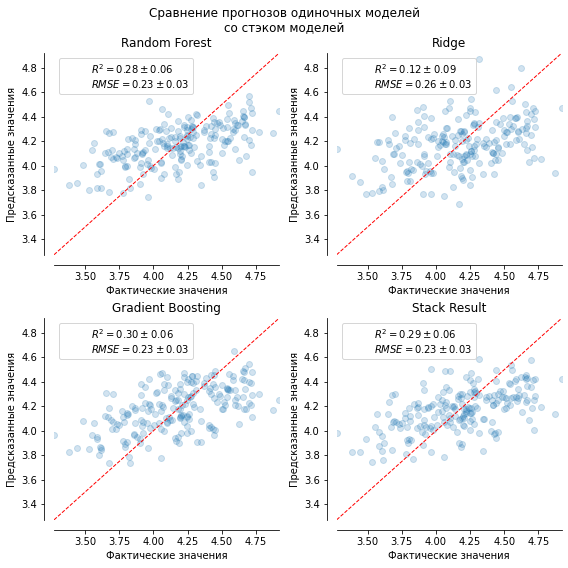

In [15]:
full_estimators = [
    ('Random Forest', RFR),    
    ('Ridge', RCV),
    ('Gradient Boosting', HGBR),
    ('Stack Result', stacking_regressor)
]

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = np.ravel(axs)
for ax, (name, est) in zip(axs, full_estimators):
    score = cross_validate(est, X, y, scoring=['r2', 'neg_mean_absolute_error'], cv=3, verbose=0)
    y_pred = cross_val_predict(est, X, y, cv=3, verbose=0)
    stacking_results(
        ax,
        y,
        y_pred,
        name,
        (r'$R^2={:.2f} \pm {:.2f}$' + '\n' + r'$RMSE={:.2f} \pm {:.2f}$').format(
            np.mean(score['test_r2']),
            np.std(score['test_r2']),
            -np.mean(score['test_neg_mean_absolute_error']),
            np.std(score['test_neg_mean_absolute_error']),
        )
    )

plt.suptitle('Сравнение прогнозов одиночных моделей\nсо стэком моделей')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

Как видно из графиков выше, с помощью стэкинга не удается достичь улучшения метрик, для предсказания на тестовом датасете может быть использова модель **HistGradientBoostingRegressor** с наилучшими параметрами на методе **GridSearchCV**.




In [16]:
HGBR.fit(X_train, y_train)
y_predict = HGBR.predict(X_test)
r2 = r2_score(y_test, y_predict)
RMSE = (-1)*mean_squared_error(y_test, y_predict)
print(r2, RMSE)

0.376973192513666 -0.061685352764937515


## Предсказание на выборке **test.xlsm**

In [17]:
df = pd.read_excel('test.xlsm', header=None, dtype=str)
dataset = df.values
dataset = [split_csv(i) for i in dataset]
test = pd.DataFrame(dataset, copy=True)
test = test.astype('float64')
test.drop(0, axis=0, inplace=True)
test.drop(0, axis=1, inplace=True)
new_columns = [f'feat_{i}' for i in range(1, len(test.columns)+1)]
test.columns = new_columns
unclaimed_columns = sparse_features + correlated_features
test.drop(unclaimed_columns, axis=1, inplace=True)
print(test.head())
print(test.info())

     feat_1    feat_2    feat_3    feat_5    feat_6    feat_7   feat_13  \
1  1.251801  0.158034  0.888123  1.009714  0.968807  1.807021  1.146804   
2  0.347331  0.091773  0.919410  0.638083  1.027207  2.072992  1.189094   
3  0.427033  0.217874  0.976771  0.742140  0.982476  1.888858  1.179335   
4  0.600732  0.286441  0.979378  0.940343  1.001735  2.025254  1.195600   
5  0.963893  0.736490  0.937661  1.168276  1.332874  1.875219  1.527412   

    feat_14   feat_16   feat_17  ...   feat_29   feat_30   feat_31   feat_32  \
1  1.741382  0.992547  0.335822  ...  1.686073  0.582570  4.995384  4.452135   
2  1.687093  0.964892  0.337046  ...  2.214145  2.153084  1.430210  0.499173   
3  1.888738  1.029420  0.337658  ...  2.742218  2.153084  2.958142  0.938391   
4  1.586270  1.020202  0.335210  ...  2.214145  0.582570  2.958142  2.695263   
5  1.780160  0.978719  0.322968  ...  4.854509  0.582570  4.486074  3.573699   

     feat_33   feat_34   feat_35   feat_36   feat_38   feat_39  
1  

In [18]:
X_ = test.values
X_ = imputer.transform(X_)
HGBR.fit(X, y)
Y_ = HGBR.predict(X_)
Y_df = pd.DataFrame(Y_)
Y_df.to_csv('predicted_Y_.csv', header=False, index=False)